In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pickle
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pylab as plt

import DDPG
import torch
from time import perf_counter

## Helper Functions

In [ ]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)    

In [3]:
def run(env, agent, n_episodes=100, noise=0):
    rewards = []
    observations = []
    actions = []
    for ep in range(1, n_episodes+1):
        start = perf_counter()
        ep_reward = 0
        state, _info = env.reset()
        for t in range(2000):
            action = agent.act(state, noise)
            state, reward, done, _trunc, _info = env.step(action)
            observations.append(state)
            actions.append(action)
            ep_reward += reward
            if done or _trunc:
                break
        rewards.append(ep_reward)
        ep_reward = 0
        print(f'Episode {ep} finished in {perf_counter()-start:.2f} seconds')
    print(f'Mean reward: {np.mean(rewards)}')
    observations = np.asarray(observations)
    actions = np.asarray(actions)
    return observations, actions, rewards

# DDPG

In [4]:
env_name = "Pendulum-v1"

eps=0.1
ts=32
lr=0.0001
s=1

with open(f"./results/DDPG_{env_name}-eps{eps}-t{ts}-l{lr}-s{s}-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    rewards = np.asarray(data["rewards"])
    losses =  np.asarray(data["losses"])

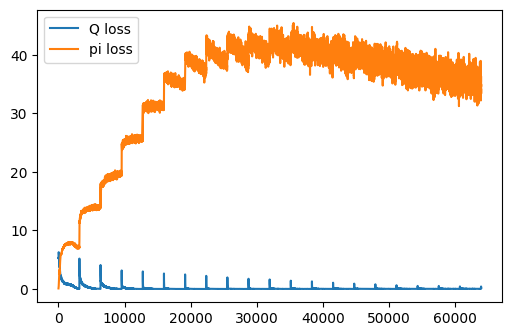

In [5]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(losses[:,0],10),label=f"Q loss")
plt.plot(running_mean(losses[:,1],10),label=f"pi loss")
plt.legend()

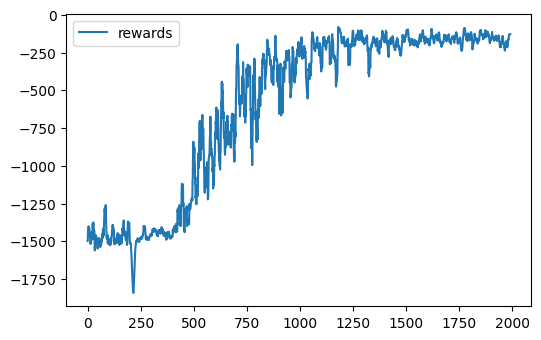

In [6]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(rewards,10),label=f"rewards")
plt.legend()

### Exploration Noise dependency

In [7]:
rewards = {}
lr = 0.0001
eps=[0.1,0.3,0.5]
ts=32
seed=1

for e in eps:
    with open(f"./results/DDPG_{env_name}-eps{e}-t{ts}-l{lr}-s{seed}-stat.pkl", 'rb') as f:
        data = pickle.load(f)
        rewards[e] = data["rewards"]

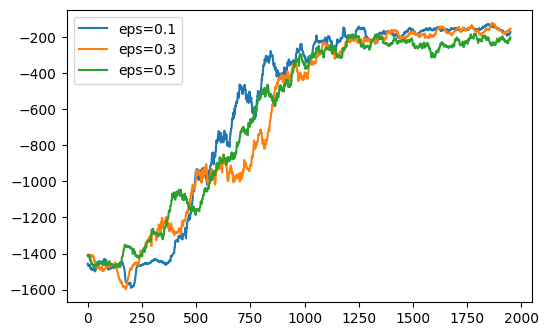

In [8]:
fig=plt.figure(figsize=(6,3.8))
for eps,rew in rewards.items():
    plt.plot(running_mean(rew,50),label=f"eps={eps}")
plt.legend()

### Update interval dependency

In [9]:
rewards = {}
lr = 0.0001
eps=0.1
ts=32
seeds=[10,20,50,100]  # we do a hack here by giving every run a different seed, as we do not export the update interval into the filename

for seed in seeds:
    with open(f"./results/DDPG_{env_name}-eps{eps}-t{ts}-l{lr}-s{seed}-stat.pkl", 'rb') as f:
        data = pickle.load(f)
        rewards[data["update_every"]] = data["rewards"]

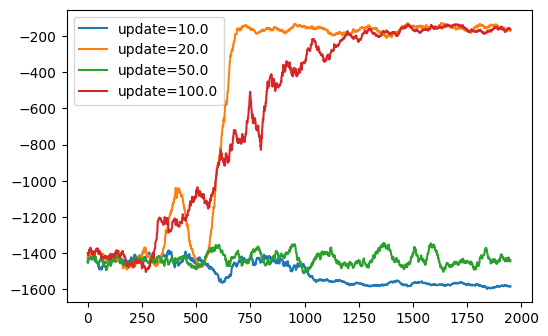

In [10]:
fig=plt.figure(figsize=(6,3.8))
for update,rew in rewards.items():
    plt.plot(running_mean(rew,50),label=f"update={update}")
plt.legend()

### Learning rate dependency

Here done for update_every 20 episodes

In [11]:
rewards = {}
lrs = [0.001, 0.0005, 0.0001, 0.00005]
eps=0.1
ts=32
seed=999

for lr in lrs:
    with open(f"./results/DDPG_{env_name}-eps{eps}-t{ts}-l{lr}-s{seed}-stat.pkl", 'rb') as f:
        data = pickle.load(f)
        rewards[data["lr"]] = data["rewards"]

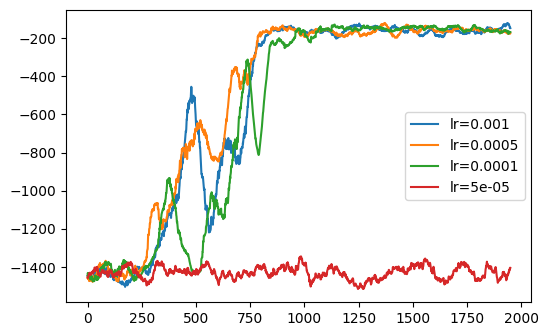

In [12]:
fig=plt.figure(figsize=(6,3.8))
for lr,rew in rewards.items():
    plt.plot(running_mean(rew,50),label=f"lr={lr}")
plt.legend()

## value function

In [13]:
def plot_Q_function(q_function, observations, actions, plot_dim1=0, plot_dim2=2,
                    label_dim1="cos(angle)", label_dim2="angular velocity"):
    plt.rcParams.update({'font.size': 12})
    values =q_function.predict(np.hstack([observations,actions]))
    
    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot()
    surf = ax.scatter (observations[:,plot_dim1], observations[:,plot_dim2],  c = values, cmap=cm.coolwarm)
    ax.set_xlabel(label_dim1)
    ax.set_ylabel(label_dim2)

    return fig

In [14]:
env = gym.make(env_name)

In [15]:
episodes=2000
eps=0.1
ts=32
lr=0.0001
checkpoint = f"./results/DDPG_{env_name}_{episodes}-eps{eps}-t{ts}-l{lr}-s1.pth"

In [16]:
agent  = DDPG.DDPGAgent(env.observation_space, env.action_space)
# agent.restore_state(torch.load(checkpoint))

RuntimeError: Error(s) in loading state_dict for QFunction:
	size mismatch for layers.0.weight: copying a param with shape torch.Size([128, 4]) from checkpoint, the shape in current model is torch.Size([256, 4]).
	size mismatch for layers.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layers.1.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for layers.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layers.2.weight: copying a param with shape torch.Size([64, 128]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for layers.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for readout.weight: copying a param with shape torch.Size([1, 64]) from checkpoint, the shape in current model is torch.Size([1, 256]).

In [17]:
observations, actions, rewards = run(env,agent,10000, noise=0.2)

Episode 1 finished in 0.05 seconds
Episode 2 finished in 0.04 seconds
Episode 3 finished in 0.04 seconds
Episode 4 finished in 0.05 seconds
Episode 5 finished in 0.04 seconds
Episode 6 finished in 0.04 seconds
Episode 7 finished in 0.05 seconds
Episode 8 finished in 0.04 seconds
Episode 9 finished in 0.04 seconds
Episode 10 finished in 0.04 seconds
Episode 11 finished in 0.04 seconds
Episode 12 finished in 0.04 seconds
Episode 13 finished in 0.04 seconds
Episode 14 finished in 0.03 seconds
Episode 15 finished in 0.04 seconds
Episode 16 finished in 0.03 seconds
Episode 17 finished in 0.05 seconds
Episode 18 finished in 0.04 seconds
Episode 19 finished in 0.03 seconds
Episode 20 finished in 0.04 seconds
Episode 21 finished in 0.04 seconds
Episode 22 finished in 0.03 seconds
Episode 23 finished in 0.04 seconds
Episode 24 finished in 0.04 seconds
Episode 25 finished in 0.03 seconds
Episode 26 finished in 0.04 seconds
Episode 27 finished in 0.04 seconds
Episode 28 finished in 0.04 seconds
E

Episode 2310 finished in 0.04 seconds
Episode 2311 finished in 0.04 seconds
Episode 2312 finished in 0.04 seconds
Episode 2313 finished in 0.04 seconds
Episode 2314 finished in 0.04 seconds
Episode 2315 finished in 0.04 seconds
Episode 2316 finished in 0.05 seconds
Episode 2317 finished in 0.04 seconds
Episode 2318 finished in 0.05 seconds
Episode 2319 finished in 0.04 seconds
Episode 2320 finished in 0.07 seconds
Episode 2321 finished in 0.05 seconds
Episode 2322 finished in 0.04 seconds
Episode 2323 finished in 0.04 seconds
Episode 2324 finished in 0.04 seconds
Episode 2325 finished in 0.04 seconds
Episode 2326 finished in 0.04 seconds


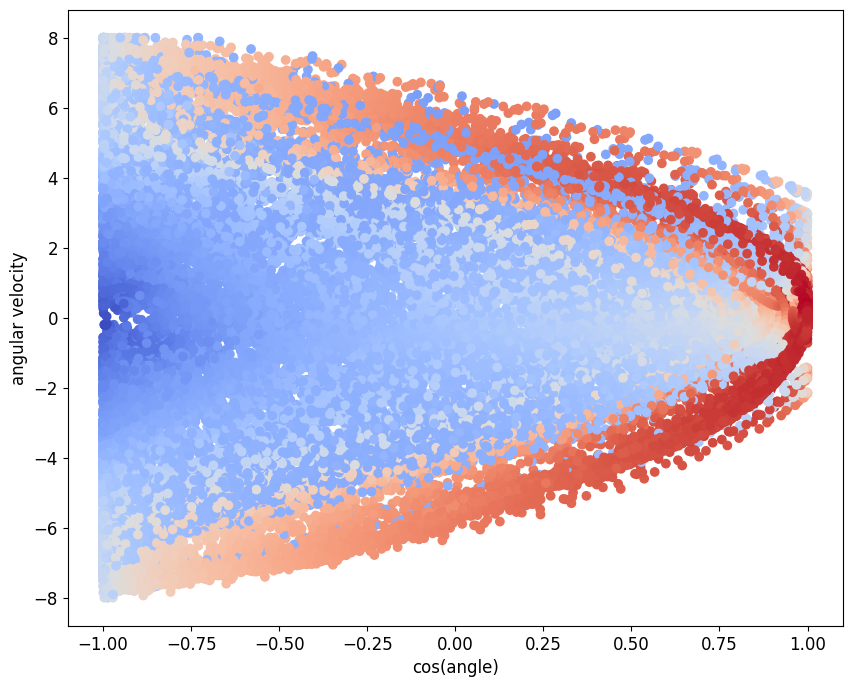

In [ ]:
_ = plot_Q_function(agent.Q,observations,actions)

## HalfCheetah

In [ ]:
env_name = "HalfCheetah-v4"

eps=0.1
ts=32
lr=0.0001
seed=1

with open(f"./results/DDPG_{env_name}-eps{eps}-t{ts}-l{lr}-s{seed}-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    rewards = np.asarray(data["rewards"])
    losses =  np.asarray(data["losses"])

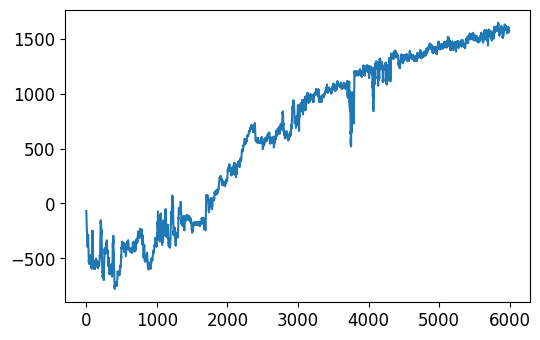

In [ ]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(rewards,10))

In [ ]:
rewards = {}
lr = 0.0001
eps=[0.1,0.3,0.5]
ts=32
seed=1

for e in eps:
    with open(f"./results/DDPG_{env_name}-eps{e}-t{ts}-l{lr}-s{seed}-stat.pkl", 'rb') as f:
        data = pickle.load(f)
        rewards[e] = data["rewards"]

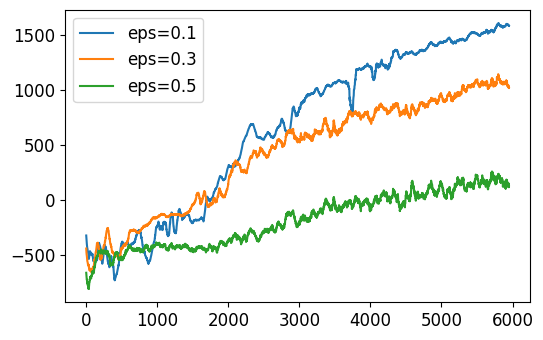

In [ ]:
fig=plt.figure(figsize=(6,3.8))
for eps,rew in rewards.items():
    plt.plot(running_mean(rew,50),label=f"eps={eps}")
plt.legend()

In [ ]:
fig.savefig(f"DDPG_{env_name}_effect_noise.pdf")

In [ ]:
env = gym.make(env_name, render_mode="human")

In [ ]:
episodes=6000
eps=0.1
checkpoint = f"./results/DDPG_{env_name}_{episodes}-eps{eps}-t{ts}-l{lr}-s1.pth"

In [ ]:
agent  = DDPG.DDPGAgent(env.observation_space, env.action_space)
agent.restore_state(torch.load(checkpoint))

In [ ]:
observations, actions, rewards = run(env,agent,2, noise=0)

/home/gekeleda/miniforge3/envs/rl/lib/python3.8/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'Wayland: Standard cursor shape unavailable'
  warnings.warn(message, GLFWError)


In [ ]:
env.close()

## Lunar Lander
The DDPG is not able to solve the Lunar Lander (at least with our implementation and the parameters we tried)

In [ ]:
env_name = "LunarLander-v2"

eps=0.1
ts=32
lr=0.0001
s=1

with open(f"./results/DDPG_{env_name}-eps{eps}-t{ts}-l{lr}-s{s}-stat.pkl", 'rb') as f:
    data = pickle.load(f)
    rewards = np.asarray(data["rewards"])
    losses =  np.asarray(data["losses"])

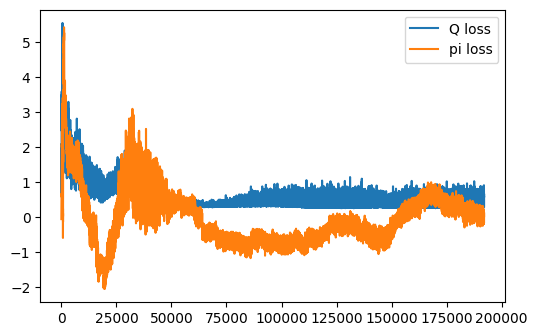

In [ ]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(losses[:,0],10),label=f"Q loss")
plt.plot(running_mean(losses[:,1],10),label=f"pi loss")
plt.legend()

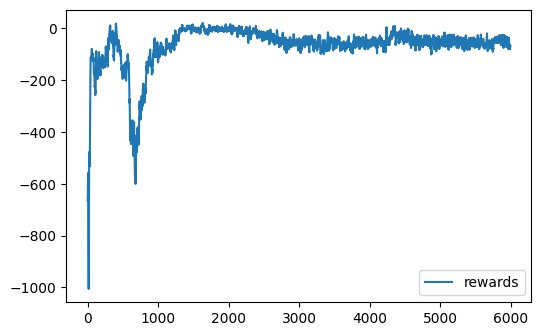

In [ ]:
fig=plt.figure(figsize=(6,3.8))
plt.plot(running_mean(rewards,10),label=f"rewards")
plt.legend()

In [ ]:
rewards = {}
lr = 0.0001
eps=[0.1,0.3,0.5]
ts=32
seed=1

for e in eps:
    with open(f"./results/DDPG_{env_name}-eps{e}-t{ts}-l{lr}-s{seed}-stat.pkl", 'rb') as f:
        data = pickle.load(f)
        rewards[e] = data["rewards"]

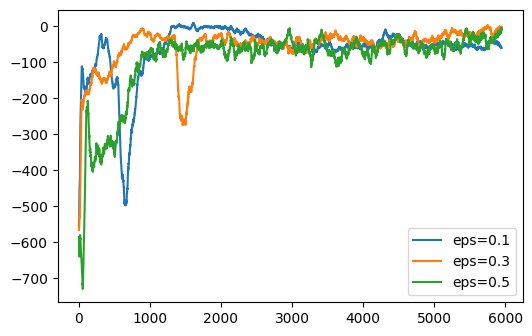

In [ ]:
fig=plt.figure(figsize=(6,3.8))
for eps,rew in rewards.items():
    plt.plot(running_mean(rew,50),label=f"eps={eps}")
plt.legend()

In [ ]:
env = gym.make(env_name, render_mode="human", continuous=True)

In [ ]:
episodes=6000
eps=0.1
checkpoint = f"./results/DDPG_{env_name}_{episodes}-eps{eps}-t{ts}-l{lr}-s1.pth"

In [ ]:
agent  = DDPG.DDPGAgent(env.observation_space, env.action_space)
agent.restore_state(torch.load(checkpoint))

In [ ]:
observations, actions, rewards = run(env,agent,2, noise=0)

Mean reward: -123.70174114226327


In [ ]:
env.close()